In [4]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import violations
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
RHO = 0.8
SIGMA = 10.0
TRUE_BETA = 2.0
study = violations.ConstantCorrelationStudy()
study.simulate(alpha=0.0, beta=TRUE_BETA, rho=RHO, sigma=SIGMA)

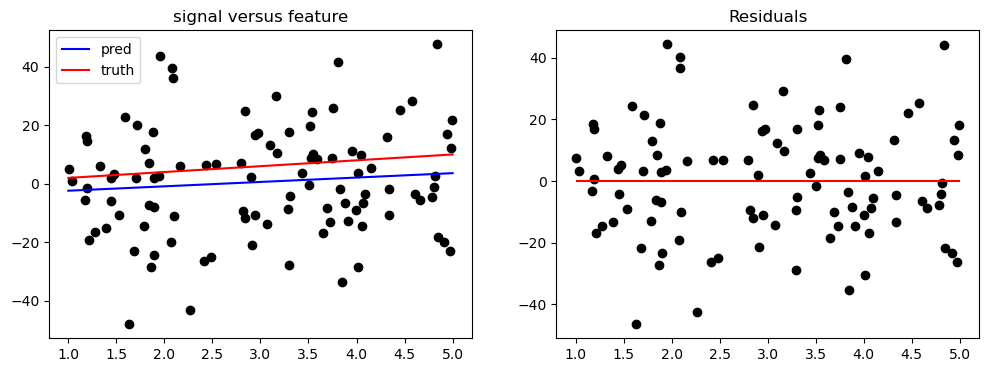

Durbin-Watson: 0.287


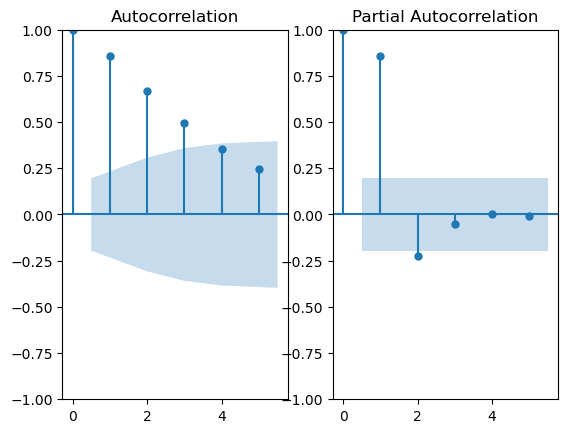

In [3]:
# Fit OLS
x = np.linspace(1, 5, 20)
model = sm.OLS(study.Y[0, :], study.X).fit()
pred = model.predict(sm.add_constant(x))
residuals = study.Y[0, :] - model.predict(study.X)

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the trend
ax1.scatter(study.X[:, 1], study.Y[0, :], c='k')
ax1.plot(x, pred, label='pred', c='blue')
ax1.plot(x, study.true_alpha + study.true_beta * x, 'red', label='truth')
ax1.set_title('signal versus feature')
ax1.legend()

# PLot residuals
ax2.hlines([0], 1, 5, color='red')
ax2.scatter(study.X[:,1], residuals, color='k')
ax2.set_title('Residuals')
plt.show()

# Check for autocorrelation in the residuals

# Durbin-Watson statistic (approaches 0 for positive correlation)
dw = sm.stats.durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.3f}")

# Ljung-Box statistic
sm.stats.acorr_ljungbox(residuals, lags=np.floor(np.log(residuals.shape[0])))

fig, (ax1, ax2) = plt.subplots(1, 2)

# ACF
sm.graphics.tsa.plot_acf(ax=ax1, x=residuals, lags=5)

# PACF
sm.graphics.tsa.plot_pacf(ax=ax2, x=residuals, lags=5)
plt.show()

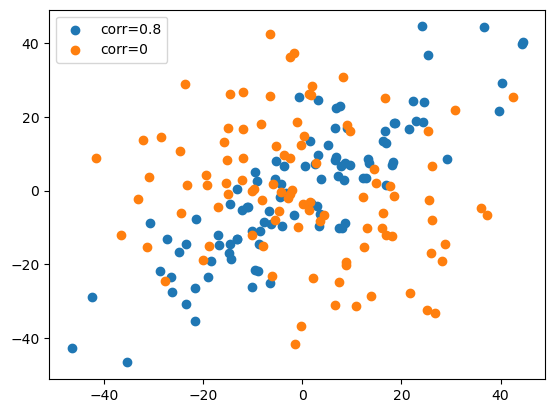

Empirical correlation: 0.856


In [4]:
tmp = np.random.normal(0, np.std(residuals), size=100)
plt.scatter(residuals[:-1], residuals[1:], label=f'corr={RHO}')
plt.scatter(tmp[:-1], tmp[1:], label='corr=0')
plt.legend()
plt.show()

corr = np.corrcoef(residuals[1:], residuals[:-1])
print(f"Empirical correlation: {corr[0, 1]:.3f}")

In [5]:
import tqdm
def beta_OLS(y, X):
    model = sm.OLS(y.ravel(), X).fit()
    intercept, slope = model.params
    return slope

# Histogram of OLS betas:

ols_betas = []
ssr = []
for i in tqdm.tqdm(range(study.n_simulations)):
    y = study.Y[i, :]
    model = sm.OLS(y, study.X).fit()
    pred = model.predict(study.X)
    intercept, slope = model.params
    ssr.append(np.sum((y - pred)**2) / (y.shape[0] - 2)) 
    ols_betas.append(slope)

100%|██████████| 10000/10000 [00:02<00:00, 4726.42it/s]


In [32]:
def compute_var_beta(X, sigma, rho):
    """
    Function that analytically computes Var(beta) assuming that 
    the errors epsilon_t are an AR(1) process satsifying

            epsilon_t = rho * epsilon_(t-1) + u_t

    where u_t ~ N(0, sigma^2).

    Returns a p-tuple where p = X.shape[1] and the i-th entry
    of the tuple is the variance of the OLS estimator for the 
    regression.

    Parameters
    ----------

    X : np.ndarray
        The design matrix. Has shape (n, p)
    sigma : float
        The true variance of the white noise u_t
    rho : float
        The true lag 1 autocorrelation of epsilon_t
    """
    
    var_eps = sigma**2 / (1 - rho**2)

    p = X.shape[1]
    Omega = np.zeros((p, p))

    # Fill in upper right triangle entries (including diag)
    for i in range(p):
        for j in range(i, p):
            # Split computation into 3 parts.

            # 1) Diagonal contribution
            Omega[i, j] += np.dot(X[:, i], X[:, j])

            # 2) +1th diagonal contribution
            Omega[i, j] += rho * np.dot(X[:-1, i], X[1:, j])
            
            # 3) -1th diagonal contribution
            Omega[i, j] += rho * np.dot(X[:-1, j], X[1:, i])

    # Copy entries into lower triangle
    for i in range(p):
        for j in range(i):
            Omega[i,j] = Omega[j, i]
    
    # Finally scale by var_eps
    Omega *= var_eps

    inv = np.linalg.inv(X.T @ X)

    res = inv @ Omega @ inv
    out = np.zeros(p)
    for i in range(p):
        out[i] = res[i, i]

    return out

alpha_var, beta_var = compute_var_beta(study.X, SIGMA, RHO)

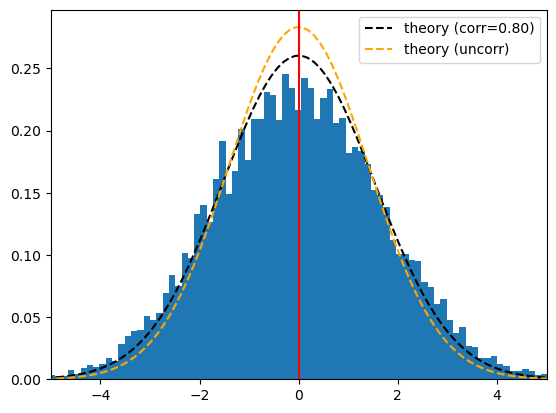

In [41]:
from scipy.stats import norm

# Theoretical sigma_ols, assuming errors are uncorrelated
sse = np.sum( (study.X[:, 1] - np.mean(study.X[:, 1]))**2 )
sigma_ols = np.sqrt( SIGMA**2 / (1 - RHO**2) / sse )

def plot_ols_beta_dist(ax, sigma, xmin=-6, xmax=6, **kwargs):

    x = np.linspace(xmin, xmax, 100)
    y = norm(0, sigma).pdf(x)
    ax.plot(x, y, **kwargs)

# Init figure
fig, ax = plt.subplots()

# Empirical distribution
_ = ax.hist(np.array(ols_betas) - 2.0, 100, density=True)
plot_ols_beta_dist(ax, sigma=beta_var**0.5, c='k', linestyle='dashed', label=f"theory (corr={RHO:.2f})")
plot_ols_beta_dist(ax, sigma=sigma_ols, c='orange', linestyle='dashed', label=f"theory (uncorr)")

# OLS distribution
plt.plot()

plt.axvline(0.0, 0.0, 1.0, c='red')
plt.xlim(-5,5)
plt.legend()
plt.show()

In [28]:
sse = np.sum((study.X[:,1] - np.mean(study.X[:,1]))**2)
SIGMA**2 / sse

np.float64(0.7138380372068026)

In [46]:
study = violations.AutocorrelationStudy(n_samples=50, n_simulations=10000)
study.simulate(beta=2.0, alpha=0.0, rho=0.9, sigma=1.0, seed=123)
study.render_plots()

Figure saved: src/broken-assumptions/figs/autocorrelation/residuals-vs-x.svg
Durbin-Watson statistic (first sim): 0.600
Ljung-Box p-value (first sim): 1.19e-06
Figure saved: src/broken-assumptions/figs/autocorrelation/acf-pacf-residuals.svg
Figure saved: src/broken-assumptions/figs/autocorrelation/lag1-residuals-scatter.svg
Figure saved: src/broken-assumptions/figs/autocorrelation/beta-distribution.svg
Figure saved: src/broken-assumptions/figs/autocorrelation/ols-fit-first-sim.svg
